<a href="https://colab.research.google.com/github/Lee-Gunju/AI-contest/blob/master/Message_passing_neural_network_for_molecular_property_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install rdkit-pypi
!pip -q install pandas
!pip -q install Pillow
!pip -q install matplotlib
!pip -q install pydot
!sudo apt-get -qq install graphviz

     |████████████████████████████████| 19.7 MB 161 kB/s 


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import logging
import gdown
import zipfile

tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

In [8]:
url = "https://drive.google.com/u/0/uc?export=download&confirm=ynH9&id=1WcW8SbDvkEwtoMR1pOrYeWNa62uYEm9z"

## data download 받고(gdown.download 사용) 압축 풀기
gdown.download(url, 'data.zip', quiet=False)

with zipfile.ZipFile('data.zip', 'r') as z_fp:
  z_fp.extractall('./data')

train = pd.read_csv('./data/train.csv')
dev = pd.read_csv('./data/dev.csv')

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=ynH9&id=1WcW8SbDvkEwtoMR1pOrYeWNa62uYEm9z
To: /content/data.zip
32.0MB [00:00, 112MB/s]


In [51]:
train = pd.concat([train, dev])
train

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724
...,...,...,...,...
66,dev_66,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846
67,dev_67,CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...,2.3537,2.3371
68,dev_68,Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...,2.1364,2.1260
69,dev_69,Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...,2.2650,2.2511


In [52]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [53]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loop. Notice, this also helps against some edge cases where the
        # last node has no edges. Alternatively, if no self-loops are used, for these
        # edge cases, zero-padding on the output of the edge network is needed.
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        atom_neighbors = atom.GetNeighbors()

        for neighbor in atom_neighbors:
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


In [54]:
label = ['S1_energy(eV)', 	'T1_energy(eV)']

In [57]:
train[label].iloc[10]

S1_energy(eV)    5.3490
T1_energy(eV)    3.8939
Name: 10, dtype: float64

In [56]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(train.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(train.shape[0] * 0.8)]
x_train = graphs_from_smiles(train.iloc[train_index].SMILES)
y_train = train[label].iloc[train_index]

# Valid set: 19 % of data
valid_index = permuted_indices[int(train.shape[0] * 0.8) : int(train.shape[0] * 0.99)]
x_valid = graphs_from_smiles(train.iloc[valid_index].SMILES)
y_valid = train[label].iloc[valid_index]

# Test set: 1 % of data
test_index = permuted_indices[int(train.shape[0] * 0.99) :]
x_test = graphs_from_smiles(train.iloc[test_index].SMILES)
y_test = train[label].iloc[test_index]

Molecule:


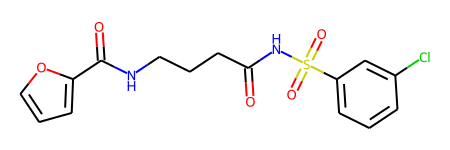

In [58]:
molecule = molecule_from_smiles(train.iloc[200].SMILES)
print("Molecule:")
molecule

In [59]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (24, 29)
	bond features	 (74, 7)
	pair indices	 (74, 2)


In [60]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices. atom_partition_indices will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    atom_partition_indices = tf.repeat(molecule_indices, num_atoms)
    bond_partition_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(
        tf.gather(increment, bond_partition_indices), [(num_bonds[0], 0)]
    )
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, atom_partition_indices), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1)

In [61]:
class EdgeNetwork(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            trainable=True,
            initializer="glorot_uniform",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), trainable=True, initializer="zeros",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.segment_sum(
            transformed_features, pair_indices[:, 0]
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate atom_features from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update aggregated atom_features via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

In [62]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):
        atom_features, atom_partition_indices = inputs

        # Obtain subgraphs
        atom_features = tf.dynamic_partition(
            atom_features, atom_partition_indices, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_padded = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch)
        nonempty_examples = tf.where(tf.reduce_sum(atom_features_padded, (1, 2)) != 0)
        nonempty_examples = tf.squeeze(nonempty_examples, axis=-1)

        return tf.gather(atom_features_padded, nonempty_examples, axis=0)


class TransformerEncoder(layers.Layer):
    def __init__(self, num_heads=8, embed_dim=64, dense_dim=512, **kwargs):
        super().__init__(**kwargs)

        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        attention_mask = mask[:, tf.newaxis, :] if mask is not None else None
        attention_output = self.attention(inputs, inputs, attention_mask=attention_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        return self.layernorm_2(proj_input + self.dense_proj(proj_input))

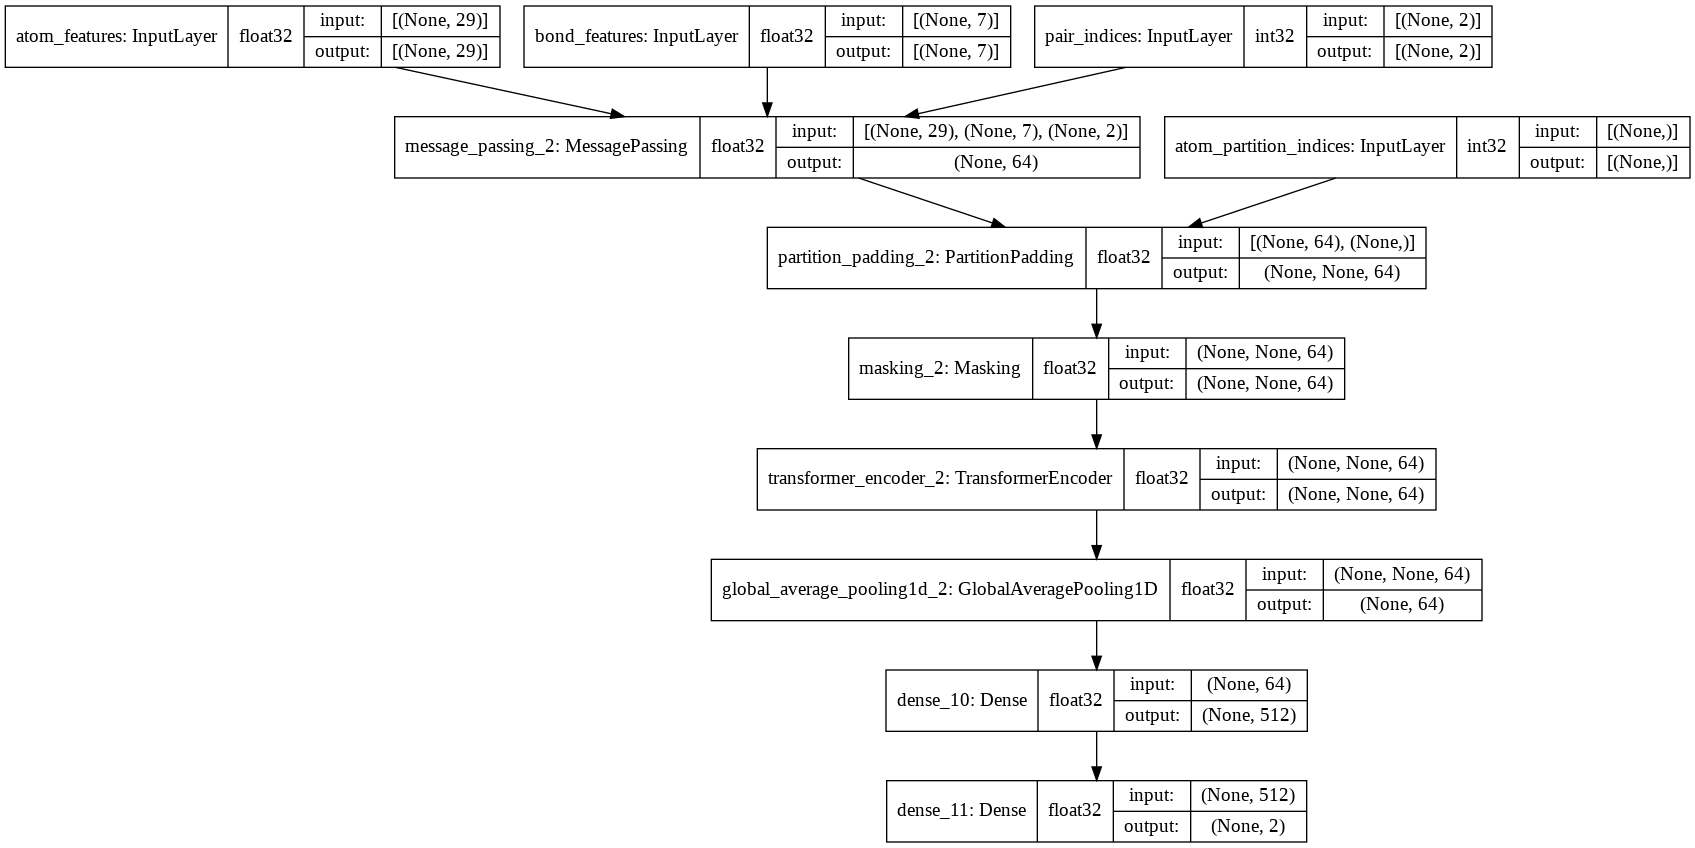

In [63]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):
    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    atom_partition_indices = layers.Input(
        (), dtype="int32", name="atom_partition_indices"
    )

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = PartitionPadding(batch_size)([x, atom_partition_indices])

    x = layers.Masking()(x)

    x = TransformerEncoder(num_attention_heads, message_units, dense_units)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(2)(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, atom_partition_indices],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss='mae',
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    #metrics=[keras.metrics.AUC(name="AUC")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

In [64]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=300,
    verbose=2,
    class_weight={0: 2.0, 1: 0.5},
)


Epoch 1/300
759/759 - 16s - loss: 0.7799 - val_loss: 0.3025
Epoch 2/300
759/759 - 12s - loss: 0.5654 - val_loss: 0.2605
Epoch 3/300
759/759 - 12s - loss: 0.5194 - val_loss: 0.2566
Epoch 4/300
759/759 - 13s - loss: 0.4807 - val_loss: 0.2351
Epoch 5/300
759/759 - 12s - loss: 0.4516 - val_loss: 0.2191
Epoch 6/300
759/759 - 12s - loss: 0.4303 - val_loss: 0.2127
Epoch 7/300
759/759 - 12s - loss: 0.4123 - val_loss: 0.2040
Epoch 8/300
759/759 - 12s - loss: 0.4003 - val_loss: 0.1978
Epoch 9/300
759/759 - 12s - loss: 0.3880 - val_loss: 0.2006
Epoch 10/300
759/759 - 12s - loss: 0.3808 - val_loss: 0.1860
Epoch 11/300
759/759 - 12s - loss: 0.3707 - val_loss: 0.1821
Epoch 12/300
759/759 - 12s - loss: 0.3590 - val_loss: 0.1759
Epoch 13/300
759/759 - 12s - loss: 0.3531 - val_loss: 0.1717
Epoch 14/300
759/759 - 12s - loss: 0.3447 - val_loss: 0.1754
Epoch 15/300
759/759 - 12s - loss: 0.3356 - val_loss: 0.1820
Epoch 16/300
759/759 - 12s - loss: 0.3298 - val_loss: 0.1735
Epoch 17/300
759/759 - 12s - loss

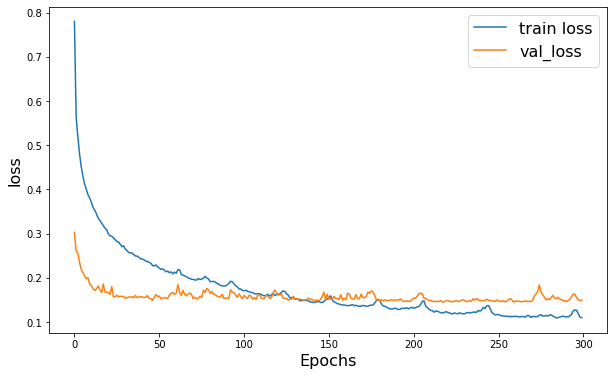

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend(fontsize=16)

In [66]:
molecules = [molecule_from_smiles(train.SMILES.values[index]) for index in test_index]
y_true = [train[label].values[index] for index in test_index]
y_pred = mpnn.predict(test_dataset)

#legends = {y_true[i]}/{y_pred[i] for i in range(len(y_true))
#MolsToGridImage(molecules, legends=legends)

In [67]:
legends = [(y_true[i] , y_pred[i] ) for i in range(len(y_true))]
legends

[(array([5.572 , 5.0983]), array([5.6454606, 5.117422 ], dtype=float32)),
 (array([5.4391, 4.9178]), array([5.425985 , 4.8691015], dtype=float32)),
 (array([3.9733, 3.1202]), array([3.8922148, 3.332109 ], dtype=float32)),
 (array([3.9946, 3.5366]), array([3.6264067, 3.4728777], dtype=float32)),
 (array([5.6994, 4.9452]), array([5.510789, 4.766033], dtype=float32)),
 (array([3.7895, 3.2819]), array([3.8264194, 3.3257482], dtype=float32)),
 (array([4.6482, 3.4595]), array([4.959946 , 3.5917892], dtype=float32)),
 (array([4.917 , 3.9389]), array([4.9652534, 3.980564 ], dtype=float32)),
 (array([4.7087, 3.656 ]), array([4.6440783, 3.6229353], dtype=float32)),
 (array([4.3822, 3.5529]), array([4.225932 , 3.7517982], dtype=float32)),
 (array([3.3634, 2.4254]), array([3.416884 , 2.4549234], dtype=float32)),
 (array([3.9193, 2.9243]), array([4.007225 , 3.0630336], dtype=float32)),
 (array([5.5479, 3.7681]), array([5.504582 , 3.7919023], dtype=float32)),
 (array([7.3439, 6.8166]), array([7.1475

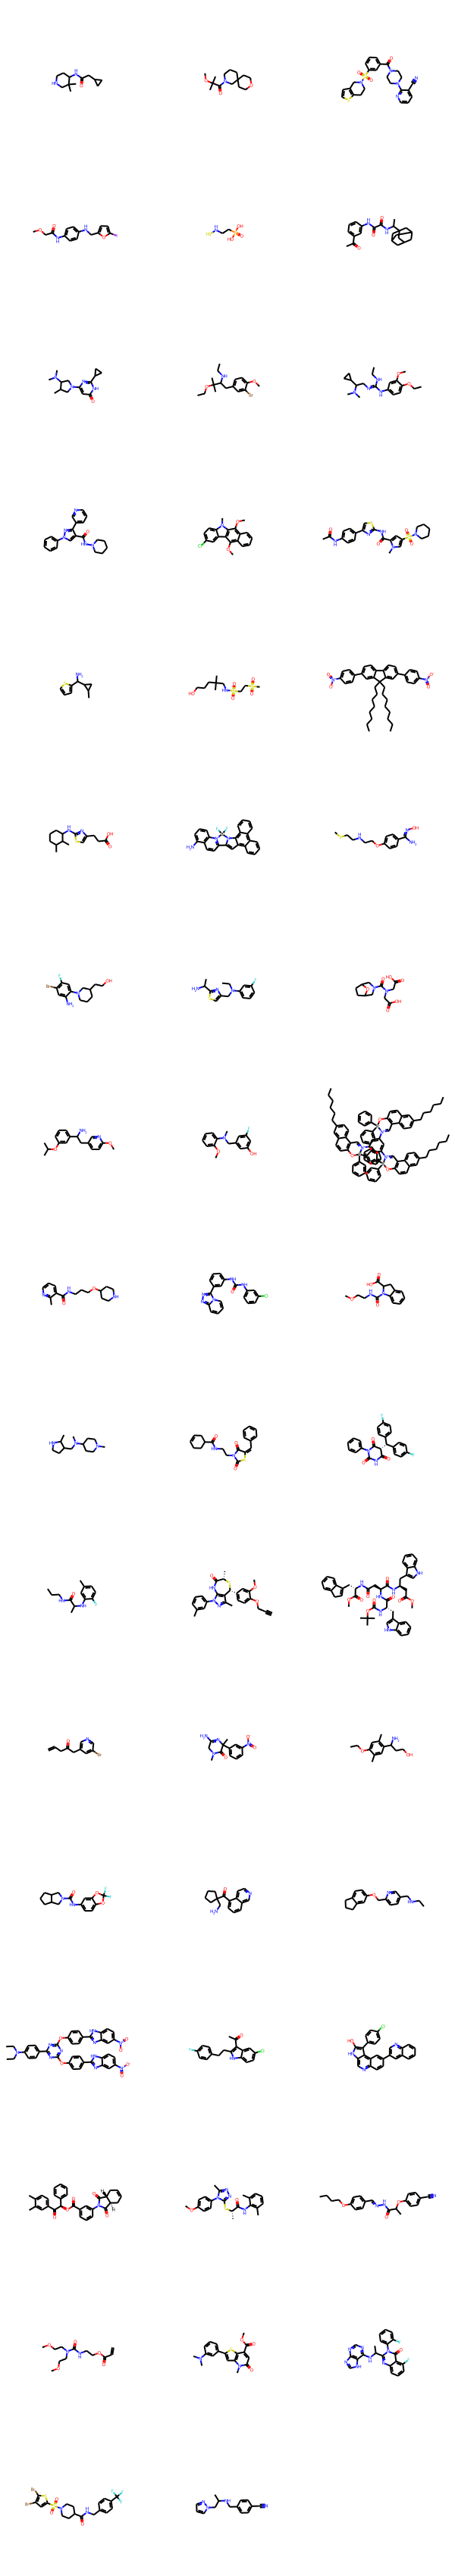

In [68]:
MolsToGridImage(molecules)